In [1]:
import os
import umap
import sys
import h5py
import torch
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from torch import nn
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import pearsonr # Pearson cor

In [2]:
# Adding initial project root to path

path_to_module = '../'

# Add this path to sys.path
if path_to_module not in sys.path:
    sys.path.insert(0, path_to_module)

In [3]:
# custom 
import common.engines as engines 
import common.plotting as plotting 
import common.dataprocessing as dataprocessing


# Travail Pratique 6 : Introduction au benchmarking de réseaux de neurones artificiels sur des données transcriptomiques de cancers.

## Importation et visualisation des données avec UMAP

#### 1. Chargement les données en python dans un format matriciel et vectoriel

In [4]:
datasets = dataprocessing.load_datasets()

In [5]:
datasets.keys()

dict_keys(['TCGA', 'BRCA', 'TALL', 'LAML'])

In [55]:
datasetname = "LAML"
tpm_data = datasets[datasetname].data
genes = datasets[datasetname].genes
labels = datasets[datasetname].labels
samples = datasets[datasetname].samples

In [56]:
samples.shape

(300,)

#### 2. Visualisation avec UMAP

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)

In [58]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, n_neighbors =10, n_epochs = 1000).fit(X_train)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Fri Dec 15 05:43:20 2023 Construct fuzzy simplicial set
Fri Dec 15 05:43:20 2023 Finding Nearest Neighbors
Fri Dec 15 05:43:20 2023 Finished Nearest Neighbor Search
Fri Dec 15 05:43:20 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Fri Dec 15 05:43:23 2023 Finished embedding


In [59]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


In [60]:
def random_color_generator():
    r = random.randint(0, 255)/256
    g = random.randint(0, 255)/256
    b = random.randint(0, 255)/256
    return (r, g, b)

In [67]:
def plot_umap(X_train_umap, X_test_umap, Y_train, Y_test, labels, s= 8):
    fig, ax1 = plt.subplots(figsize=(12,7))
    ax1.grid(visible=True,linestyle="--")
    ax1.set_axisbelow(True)
    markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])
    colors_by_ctype = [random_color_generator() for  i in range(len(np.unique(labels)))]
    for (i,lbl) in enumerate(np.unique(labels)):
        #defin_ = tcga_abbrevs.loc[tcga_abbrevs["abbrv"] == lbl,"def"].values[0] 
        #count_ = counts_df.loc[counts_df["c_type"] == lbl,"count"].values[0]
        #tag = f"{defin_} ({count_})"
        #print(X_tr_tsne[labels ==lbl,0])
        ax1.scatter(X_train_umap[Y_train ==lbl,0], 
                X_train_umap[Y_train ==lbl,1], 
                s = s, color = colors_by_ctype[i], linewidth = 0.5, marker=markers_[i], label = lbl)
        ax1.scatter(X_test_umap[Y_test ==lbl,0], 
                X_test_umap[Y_test ==lbl,1], 
                s = s, edgecolors = colors_by_ctype[i], color ="white", linewidth = 0.5, marker=markers_[i])

    ax1.axis("equal")
    ax1.legend(bbox_to_anchor=(1,1),fontsize = 8, title="Type of cancer")
    ax1.set_xlabel("UMAP1")
    ax1.set_ylabel("UMAP2")
    #fig.tight_layout()
    plt.title(f"UMAP analysis of gene expression with the test points for {datasetname} data")
    plt.tight_layout()
    plt.savefig(f"figures/figUMAP_{datasetname}.svg", format="svg")

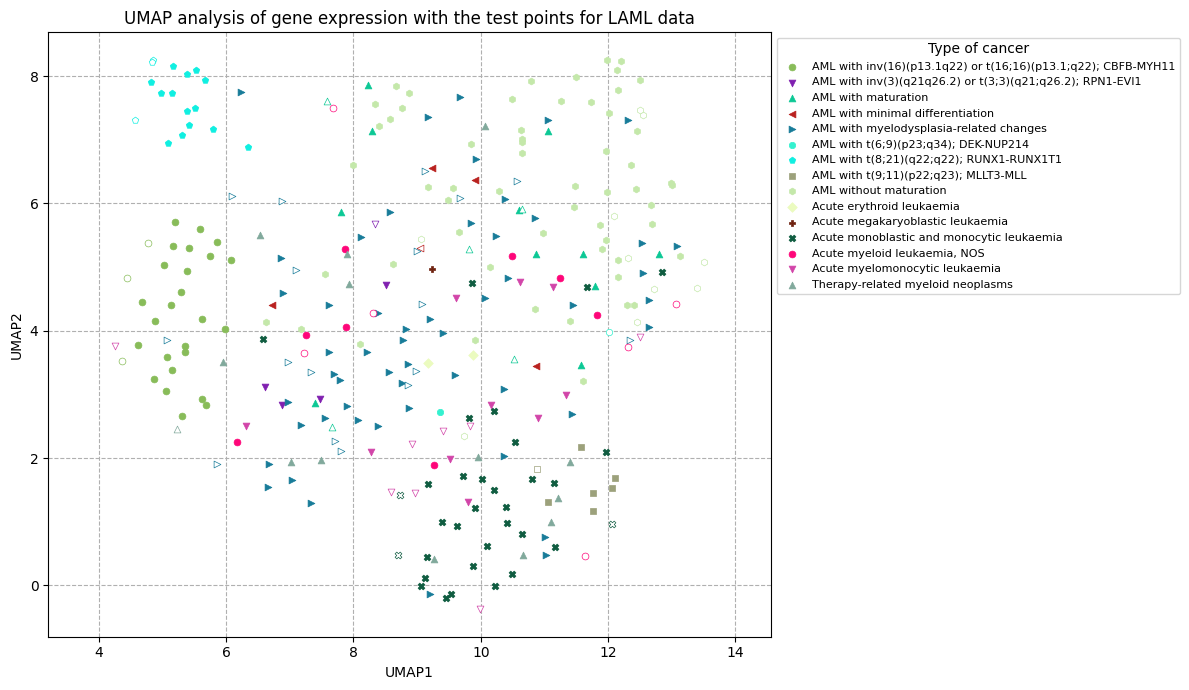

In [68]:
plot_umap(X_tr_umap, X_tst_umap, Y_train, Y_test, labels, s=24)

## II. Création d'un réseau de neurones artificiel pour un problème de régression avec un auto-encodeur. 

#### 1. Créez une fonction qui construit un modèle DNN selon la structure <code>encoder => bottleneck => decoder</code>

In [30]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [31]:
mm,encoder  = engines.auto_encoder(insize, insize, 2)
encoder(X_train).shape
mm.parameters()

<generator object Module.parameters at 0x7f0aa0cff8b0>

#### 2. Lancez un entrainement de 1000 epochs et enregistrez la performance du modèle par epoch sous la forme de l'erreur et la correlation de Pearson sur l'ensemble de test et de train

In [ ]:
mm, trl, tstl, trc, tstc  = engines.train_auto_encoder(insize, 2, X_train, X_test, nepochs = 300, lr = 5 * 1e-4)

Loss 0 Train - loss : 0.178 - acc : 0.001 Test acc : 0.001
Loss 10 Train - loss : 0.154 - acc : 0.041 Test acc : 0.041
Loss 20 Train - loss : 0.136 - acc : 0.086 Test acc : 0.087
Loss 30 Train - loss : 0.122 - acc : 0.135 Test acc : 0.136
Loss 40 Train - loss : 0.111 - acc : 0.185 Test acc : 0.186
Loss 50 Train - loss : 0.1 - acc : 0.23 Test acc : 0.231
Loss 60 Train - loss : 0.081 - acc : 0.269 Test acc : 0.269
Loss 70 Train - loss : 0.046 - acc : 0.442 Test acc : 0.444
Loss 80 Train - loss : 0.028 - acc : 0.63 Test acc : 0.635
Loss 90 Train - loss : 0.027 - acc : 0.65 Test acc : 0.655
Loss 100 Train - loss : 0.027 - acc : 0.651 Test acc : 0.656
Loss 110 Train - loss : 0.026 - acc : 0.658 Test acc : 0.663
Loss 120 Train - loss : 0.026 - acc : 0.66 Test acc : 0.665
Loss 130 Train - loss : 0.026 - acc : 0.661 Test acc : 0.666
Loss 140 Train - loss : 0.026 - acc : 0.661 Test acc : 0.667
Loss 150 Train - loss : 0.026 - acc : 0.662 Test acc : 0.667
Loss 160 Train - loss : 0.026 - acc : 0.6

#### 3. Produisez la courbe d'apprentissage de l'entrainement de ce réseau, c'est à dire la courbe de l'erreur sur le test et le train et la corrélation de Pearson selon les epochs.

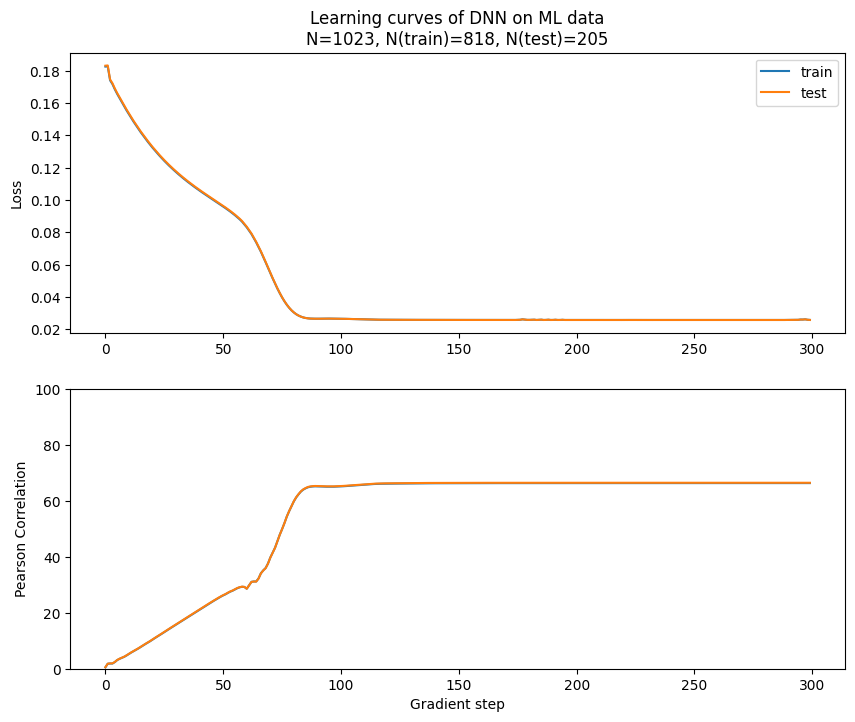

In [29]:
plotting.plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)

### II.3 Produisez la courbe d'apprentissage de l'entrainement de ce réseau, c'est à dire la courbe de l'erreur sur le test et le train et la corrélation de Pearson selon les epochs.

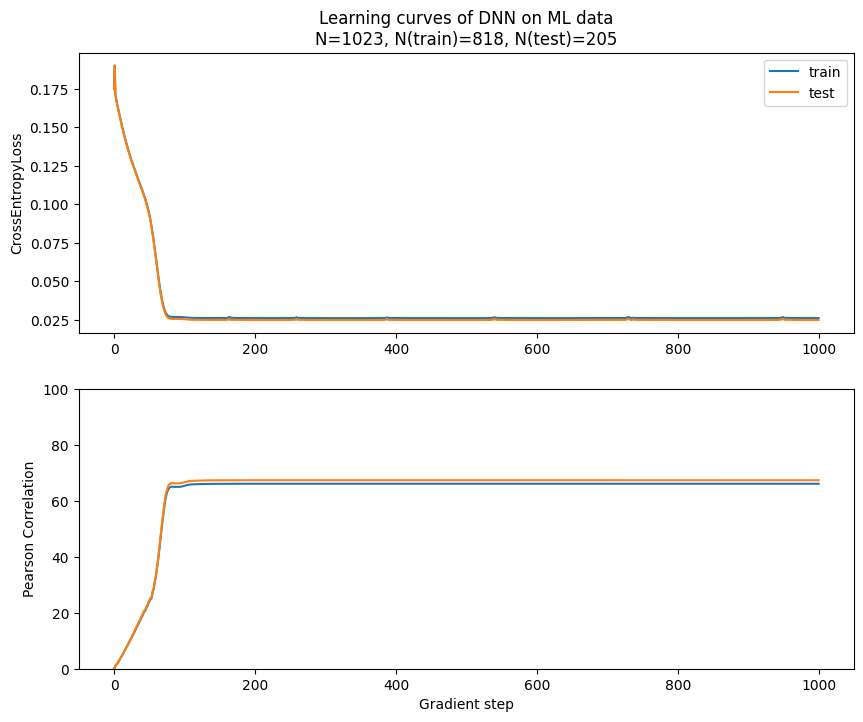

In [ ]:
plotting.plot_learning_curves(trl, tstl, trc, tstc, data, X_train, X_test)

### II.4 Faites la visualisation de la corrélation sur les données de test prédites et vraies. Rapportez votre résultat sous la forme d'un histogramme 2D avec des hexagones, l'échelle de la densité doit être rapportées.

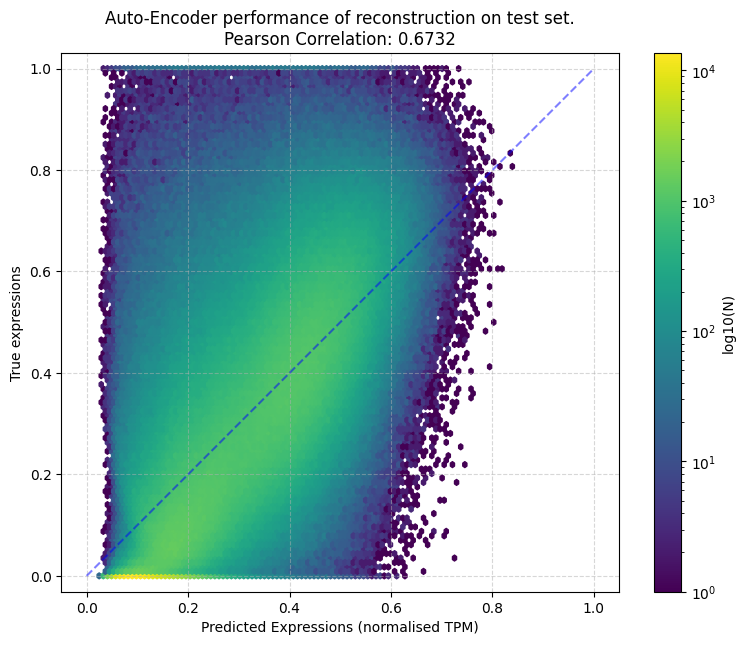

In [ ]:
plotting.plot_ae_performance(mm, X_test)

## III. Variational Auto-Encoders (VAE) pour un gain de performance de reconstruction dans les problèmes de régression.

## IV. UMAP supervise

## V. Auto-Encodeurs supervises.

## VI. VAE supervises (seance 2)

## VII. Introduction au benchmarking, comparaison de methodes

## III. Classification de sous-types de cancers du sein et comparaison de methodes entre la regression logistique regularisee et un modele d'apprentissage profond.